***Vorlesung 'Syntax natürlicher Sprachen'***

--- 
# Vorlesung 07: Subkategorisierung, Invertierung, Gap-Features

In [1]:
import nltk
from nltk import Tree
from nltk.featstruct import FeatStruct

In [2]:
def test_fcfg_grammar(gramstring, sent, draw=0, tracing=0):
    grammar = nltk.grammar.FeatureGrammar.fromstring(gramstring)
    parser = nltk.parse.FeatureChartParser(grammar,trace=tracing)
    analyzed = False
    for tree in parser.parse(sent):
        if not draw: print(tree)
        if draw: 
            tree = Tree.fromstring(str(tree).replace(", ",","))
            #tree.pretty_print(unicodelines=True)
            display(tree)
        analyzed = True
    if not analyzed:
        print("Keine Analyse möglich")    

def test_cfg_grammar(grammar, sent, tracing=0):
    parser = nltk.ChartParser(grammar,trace=tracing)
    analyzed = False
    for tree in parser.parse(sent):
        tree.pretty_print(unicodelines=True)
        analyzed = True
    if not analyzed:
        print("Keine Analyse möglich")

---
## 1. Modellierung von Kasus, Agreement und Subkategorisierung (german.fcfg)


### A) Übergenerierende CFG:

In [3]:
grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Det N
VP -> V
VP -> V NP

Det -> 'der' | 'dem' | 'den' | 'die'
N -> 'Hund' | 'Hunde' |'Hunden' |'Katze' |'Katzen'
V -> 'sieht' | 'sehen' | 'hilft' | 'helfen' | 'läuft' | 'laufen'
""")

In [4]:
sent = 'der Hund sieht die Katze'.split()
test_cfg_grammar(grammar, sent)

               S                
     ┌─────────┴────┐            
     │              VP          
     │         ┌────┴───┐        
     NP        │        NP      
 ┌───┴───┐     │    ┌───┴────┐   
Det      N     V   Det       N  
 │       │     │    │        │   
der     Hund sieht die     Katze



In [5]:
#VERLETZUNG SUBKATEGORISIERUNG:
sent = 'der Hund sieht'.split()
test_cfg_grammar(grammar, sent)
#Übergenerierung!

         S        
     ┌───┴─────┐   
     NP        VP 
 ┌───┴───┐     │   
Det      N     V  
 │       │     │   
der     Hund sieht



In [6]:
#VERLETZUNG SUBJEKT-KONGRUENZ:
sent = 'der Hund sehen die Katze'.split()
test_cfg_grammar(grammar, sent)
#Übergenerierung!

               S                
     ┌─────────┴────┐            
     │              VP          
     │         ┌────┴───┐        
     NP        │        NP      
 ┌───┴───┐     │    ┌───┴────┐   
Det      N     V   Det       N  
 │       │     │    │        │   
der     Hund sehen die     Katze



In [7]:
#VERLETZUNG KASUS-REKTION:
sent = 'dem Hund sieht der Katze'.split()
test_cfg_grammar(grammar, sent)
#Übergenerierung!

               S                
     ┌─────────┴────┐            
     │              VP          
     │         ┌────┴───┐        
     NP        │        NP      
 ┌───┴───┐     │    ┌───┴────┐   
Det      N     V   Det       N  
 │       │     │    │        │   
dem     Hund sieht der     Katze



---
### B) FCFG mit Constraints zur Verhinderung der Übergenerierung:

- https://www.nltk.org/book/ch09.html#case-and-gender-in-german
- vgl. https://www.nltk.org/book/ch09.html#subcategorization

In [8]:
gramstring = r"""
% start S

S -> NP[CASE=nom, AGR=?a] VP[AGR=?a]

NP[CASE=?c, AGR=?n] -> Det[CASE=?c, AGR=?n] N[CASE=?c, AGR=?n]

VP[AGR=?v] -> V[AGR=?v, SUBCAT=0]
VP[AGR=?v] -> V[OBJCASE=?c, AGR=?v, SUBCAT=1] NP[CASE=?c]

## Übersicht Constraints (als Pfadgleichungen):
    ## Subjekt-Kasusrektion = Zeile 4: <NP CASE> = nom 
    ## Objekt-Kasusrektion = Zeile 9: <V OBJCASE> = <NP CASE>
    ## Subjektkongruenz = Zeile 4: <NP AGR> = <VP AGR>
    ## Subkategorisierung = Zeilen 8,9: <V SUBCAT>= 0/1

    ## nominale Kongruenz = Zeile 6: <Det AGR> = <N AGR>

# masc
Det[CASE=nom, AGR=[GND=masc,PER=3,NUM=sg]] -> 'der' 
Det[CASE=dat, AGR=[GND=masc,PER=3,NUM=sg]] -> 'dem'
Det[CASE=acc, AGR=[GND=masc,PER=3,NUM=sg]] -> 'den'

# fem
Det[CASE=nom, AGR=[GND=fem,PER=3,NUM=sg]] -> 'die' 
Det[CASE=dat, AGR=[GND=fem,PER=3,NUM=sg]] -> 'der'
Det[CASE=acc, AGR=[GND=fem,PER=3,NUM=sg]] -> 'die' 


# Plural determiners
Det[CASE=nom, AGR=[PER=3,NUM=pl]] -> 'die' 
Det[CASE=dat, AGR=[PER=3,NUM=pl]] -> 'den' 
Det[CASE=acc, AGR=[PER=3,NUM=pl]] -> 'die' 

# Nouns
N[AGR=[GND=masc,PER=3,NUM=sg]] -> 'Hund'
N[CASE=nom, AGR=[GND=masc,PER=3,NUM=pl]] -> 'Hunde'
N[CASE=dat, AGR=[GND=masc,PER=3,NUM=pl]] -> 'Hunden'
N[CASE=acc, AGR=[GND=masc,PER=3,NUM=pl]] -> 'Hunde'

N[AGR=[GND=fem,PER=3,NUM=sg]] -> 'Katze'
N[AGR=[GND=fem,PER=3,NUM=pl]] -> 'Katzen'

# Verbs
V[OBJCASE=acc, AGR=[NUM=sg,PER=3], SUBCAT=1] -> 'sieht'
V[OBJCASE=acc, AGR=[NUM=pl,PER=3], SUBCAT=1] -> 'sehen'
V[OBJCASE=dat, AGR=[NUM=sg,PER=3], SUBCAT=1] -> 'hilft'
V[OBJCASE=dat, AGR=[NUM=pl,PER=3], SUBCAT=1] -> 'helfen'
V[AGR=[NUM=sg,PER=3], SUBCAT=0] -> 'läuft'
V[AGR=[NUM=pl,PER=3], SUBCAT=0] -> 'laufen' 
"""

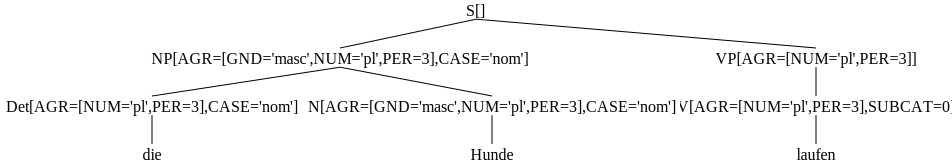

In [9]:
sent = 'die Hunde laufen'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

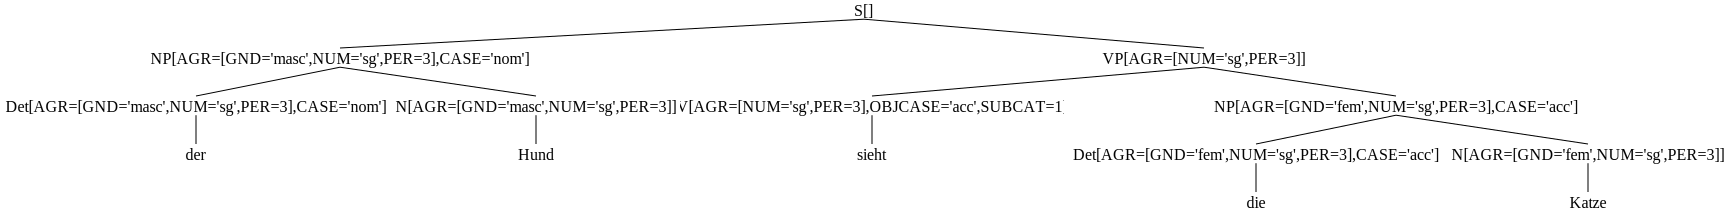

In [10]:
sent = 'der Hund sieht die Katze'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

In [11]:
#VERLETZUNG SUBKATEGORISIERUNG:
sent = 'der Hund sieht'.split()
test_fcfg_grammar(gramstring, sent)

Keine Analyse möglich


In [12]:
#VERLETZUNG SUBJEKT-KONGRUENZ:
sent = 'der Hund sehen die Katze'.split()
test_fcfg_grammar(gramstring, sent)

Keine Analyse möglich


In [13]:
#VERLETZUNG KASUS-REKTION:
sent = 'dem Hund sieht der Katze'.split()
test_fcfg_grammar(gramstring, sent)

Keine Analyse möglich


---
### Weitere Beispiele mit Tracing:

|.der .Hund.läuf.|
Leaf Init Rule:
|[----]    .    .| [0:1] 'der'
|.    [----]    .| [1:2] 'Hund'
|.    .    [----]| [2:3] 'läuft'
Feature Bottom Up Predict Combine Rule:
|[----]    .    .| [0:1] Det[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] -> 'der' *
|[----]    .    .| [0:1] Det[AGR=[GND='fem', NUM='sg', PER=3], CASE='dat'] -> 'der' *
Feature Bottom Up Predict Combine Rule:
|[---->    .    .| [0:1] NP[AGR=?n, CASE=?c] -> Det[AGR=?n, CASE=?c] * N[AGR=?n, CASE=?c] {?c: 'dat', ?n: [GND='fem', NUM='sg', PER=3]}
Feature Bottom Up Predict Combine Rule:
|[---->    .    .| [0:1] NP[AGR=?n, CASE=?c] -> Det[AGR=?n, CASE=?c] * N[AGR=?n, CASE=?c] {?c: 'nom', ?n: [GND='masc', NUM='sg', PER=3]}
Feature Bottom Up Predict Combine Rule:
|.    [----]    .| [1:2] N[AGR=[GND='masc', NUM='sg', PER=3]] -> 'Hund' *
Feature Single Edge Fundamental Rule:
|[---------]    .| [0:2] NP[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] -> Det[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] N[AGR=[GND='masc', NUM

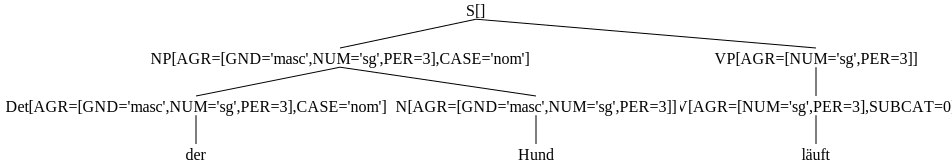

In [14]:
#Positivbeispiel:
sent = 'der Hund läuft'.split()
test_fcfg_grammar(gramstring, sent, draw=1,tracing=2)

In [15]:
#VERLETZUNG SUBJEKT-KONGRUENZ:
sent = 'der Hund laufen'.split()
test_fcfg_grammar(gramstring, sent, draw=0,tracing=2)

|.der .Hund.lauf.|
Leaf Init Rule:
|[----]    .    .| [0:1] 'der'
|.    [----]    .| [1:2] 'Hund'
|.    .    [----]| [2:3] 'laufen'
Feature Bottom Up Predict Combine Rule:
|[----]    .    .| [0:1] Det[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] -> 'der' *
|[----]    .    .| [0:1] Det[AGR=[GND='fem', NUM='sg', PER=3], CASE='dat'] -> 'der' *
Feature Bottom Up Predict Combine Rule:
|[---->    .    .| [0:1] NP[AGR=?n, CASE=?c] -> Det[AGR=?n, CASE=?c] * N[AGR=?n, CASE=?c] {?c: 'dat', ?n: [GND='fem', NUM='sg', PER=3]}
Feature Bottom Up Predict Combine Rule:
|[---->    .    .| [0:1] NP[AGR=?n, CASE=?c] -> Det[AGR=?n, CASE=?c] * N[AGR=?n, CASE=?c] {?c: 'nom', ?n: [GND='masc', NUM='sg', PER=3]}
Feature Bottom Up Predict Combine Rule:
|.    [----]    .| [1:2] N[AGR=[GND='masc', NUM='sg', PER=3]] -> 'Hund' *
Feature Single Edge Fundamental Rule:
|[---------]    .| [0:2] NP[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] -> Det[AGR=[GND='masc', NUM='sg', PER=3], CASE='nom'] N[AGR=[GND='masc', NU

---
## 2. Verhinderung Überproduktion durch invertierte NP - V -Regel für Auxiliarkonstruktion

- https://www.nltk.org/book/ch09.html#auxiliary-verbs-and-inversion


### A) CFG mit Übergenerierung bei AUX-Konstruktion:

In [16]:
grammar = nltk.CFG.fromstring("""
    S   -> NP VP
    
    VP  -> VERBAL  
    VERBAL -> V NP
    
    VP -> AUX VERBAL
 #invertierte NP-V-Regeln für AUX-VP:
    VERBAL -> NP V

    NP  -> DET NOM
    NOM -> N
 
    DET -> "der" | "den"
    N   -> "Hund" | "Briefträger"
    V   -> "übergibt"
    AUX -> "hat"
    V -> "übergeben"
""")

In [17]:
#Positivbeispiel Präsens:
sent = 'der Briefträger übergibt den Hund'.split()
test_cfg_grammar(grammar, sent)

                       S                    
     ┌─────────────────┴───────┐             
     │                         VP           
     │                         │             
     │                       VERBAL         
     │                 ┌───────┴─────┐       
     NP                │             NP     
 ┌───┴───────┐         │       ┌─────┴───┐   
 │          NOM        │       │        NOM 
 │           │         │       │         │   
DET          N         V      DET        N  
 │           │         │       │         │   
der     Briefträger übergibt  den       Hund



In [18]:
#Positivbeispiel Perfekt:
sent = 'der Briefträger hat den Hund übergeben'.split()
test_cfg_grammar(grammar, sent)

                     S                          
     ┌───────────────┴───────┐                   
     │                       VP                 
     │               ┌───────┴────┐              
     │               │          VERBAL          
     │               │       ┌────┴────────┐     
     NP              │       NP            │    
 ┌───┴───────┐       │   ┌───┴────┐        │     
 │          NOM      │   │       NOM       │    
 │           │       │   │        │        │     
DET          N      AUX DET       N        V    
 │           │       │   │        │        │     
der     Briefträger hat den      Hund  übergeben



In [19]:
#Negativbeispiel Präsens (mit Perfektregel):
sent = 'der Briefträger den Hund übergibt'.split()
test_cfg_grammar(grammar, sent)
#Übergenerierung!

                     S                     
     ┌───────────────┴────────┐             
     │                        VP           
     │                        │             
     │                      VERBAL         
     │                   ┌────┴───────┐     
     NP                  NP           │    
 ┌───┴───────┐       ┌───┴────┐       │     
 │          NOM      │       NOM      │    
 │           │       │        │       │     
DET          N      DET       N       V    
 │           │       │        │       │     
der     Briefträger den      Hund  übergibt



In [20]:
#Negativbeispiel Perfekt (mit Präsensregel):
sent = 'der Briefträger hat übergeben den Hund'.split()
test_cfg_grammar(grammar, sent)
#Übergenerierung!

                     S                               
     ┌───────────────┴─────────────┐                  
     │                             VP                
     │               ┌─────────────┴────┐             
     │               │                VERBAL         
     │               │      ┌───────────┴─────┐       
     NP              │      │                 NP     
 ┌───┴───────┐       │      │           ┌─────┴───┐   
 │          NOM      │      │           │        NOM 
 │           │       │      │           │         │   
DET          N      AUX     V          DET        N  
 │           │       │      │           │         │   
der     Briefträger hat übergeben      den       Hund



--- 
### B) Lösung Übergenerierung mit binärem PP-Feature:

##### PP = Partizip Perfekt

In [21]:
gramstring = r"""
% start S

    S   -> NP VP
    
    VP[-INV]  -> VERBAL
    VERBAL -> V[-PP] NP
    
    VP[+INV] -> V[+AUX] VERBAL
 #invertierte NP-V-Regeln für AUX-VP:    
    VERBAL -> NP V[-AUX,+PP]

    NP  -> DET NOM
    NOM -> N
 
    DET -> "der" | "den"
    N   -> "Hund" | "Briefträger"
    V[-AUX,-PP]   -> "übergibt"
    V[+AUX] -> "hat"
    V[-AUX,+PP] -> "übergeben"
"""

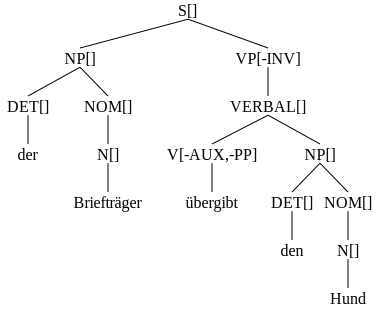

In [22]:
#Positivbeispiel Präsens:
sent = 'der Briefträger übergibt den Hund'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

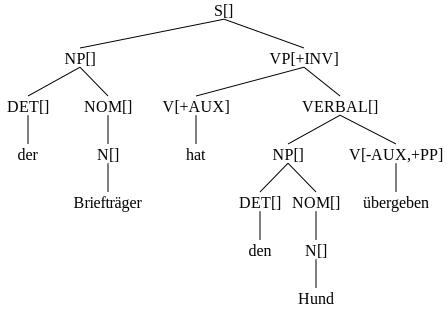

In [23]:
#Positivbeispiel Perfekt:
sent = 'der Briefträger hat den Hund übergeben'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

In [24]:
#Negativbeispiel Präsens (mit Perfektregel):
sent = 'der Briefträger den Hund übergibt'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

Keine Analyse möglich


In [25]:
#Negativbeispiel Perfekt (mit Präsensregel):
sent = 'der Briefträger hat übergeben den Hund'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

Keine Analyse möglich



--- 


## 3. FCFG mit Gap-Introduction (*Long Distance Dependencies*)

- https://www.nltk.org/book/ch09.html#unbounded-dependency-constructions


### A) Ausgangsgrammatik ohne Inversionsregel und Gap-Introduction:

In [26]:
gramstring = r"""
% start S

    S -> NP[-QUEST] VP
    VP  -> V[+AUX] NP V[+PP]    
    NP[QUEST=?x] -> PRON[QUEST=?x]

    PRON[-QUEST]   -> "sie"
    PRON[-QUEST]   -> "ihn"
    PRON[+QUEST]   -> "wen"
    
    V[+AUX] -> "hat"
    V[+PP]   -> "gesehen" 
"""

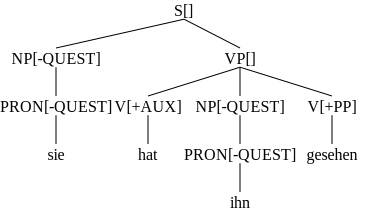

In [27]:
sent = 'sie hat ihn gesehen'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

In [28]:
#Entscheidungsfragesatz: Regeln fehlen noch!
sent = 'hat sie ihn gesehen'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

Keine Analyse möglich


In [29]:
#Ergänzungsfragesatz (nach Objekt): Regeln fehlen noch!
sent = 'wen hat sie gesehen'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

Keine Analyse möglich


---

### B) Regeln für Auxiliar-Subjekt-NP-Inversion im Entscheidungsfragesatz:


In [30]:
gramstring = r"""
% start S
    
    S[-INV] -> NP[-QUEST] VP
    VP -> V[+AUX] NP[-QUEST] V[+PP]
    NP[QUEST=?x] -> PRON[QUEST=?x]
    
#Invertierter Satz:   
    S[+INV] -> V[+AUX] NP VP

#VP-Regel für invertierten Satz:
    VP -> NP V[+PP]


    PRON[-QUEST]   -> "sie"
    PRON[-QUEST]   -> "ihn"
    PRON[+QUEST]   -> "wen" 
    
    V[+AUX] -> "hat"
    V[+PP]   -> "gesehen" 
"""

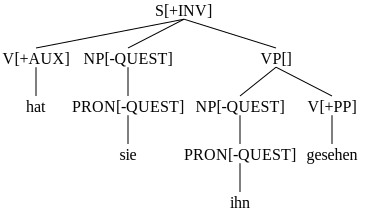

In [31]:
#Entscheidungsfragesatz: AUX NP (NP V)=VP 
#Inversion AUX-Subjekt-NP
sent = 'hat sie ihn gesehen'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

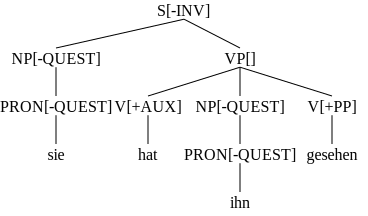

In [32]:
#Aussagesatz: NP (AUX NP V)=VP 
sent = 'sie hat ihn gesehen'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

---

### C) Erweiterung um Gap-Feature mit Slash-Syntax für Ergänzungsfragesatz:

- `VP/NP` entspricht `VP[SLASH=NP]` (NLTK verarbeitet Slash als Merkmal)  
- `VP/NP` = *VP ohne NP / mit NP-Lücke*
- `NP/NP -> ` = Realisierung *NP ohne NP* als leeren String (ε)

In [33]:
gramstring = r"""
% start S
    
    S[-INV] -> NP[-QUEST] VP[+INV]
    VP[+INV] -> V[+AUX] NP[-QUEST] V[+PP]
    NP[QUEST=?x] -> PRON[QUEST=?x]

    S[+INV] -> V[+AUX] NP VP
    VP -> NP V[+PP]

#Movement Objekt (Gap-Introduction):
    S[+MOVEMENT]  -> NP[+QUEST] S[+INV]/NP

#Gap-Informationen herunterreichen: 
    S[+INV]/?x -> V[+AUX] NP VP/?x
    VP/?x  -> NP/?x V[+PP] 

#Gap-Realisierung:
    NP/NP ->

    PRON[-QUEST]   -> "sie"
    PRON[-QUEST]   -> "ihn"
    PRON[+QUEST]   -> "wen" 
    
    V[+AUX] -> "hat"
    V[+PP]   -> "gesehen" 
"""

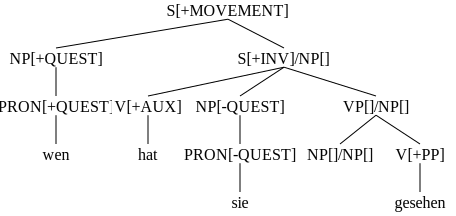

In [34]:
#Ergänzungsfragesatz (nach Objekt): NP[+QUEST] AUX NP (_NP-GAP_ V)=VP/NP 
#Movement Objekt-NP
sent = 'wen hat sie gesehen'.split()
test_fcfg_grammar(gramstring, sent, draw=1)


--- 


## 4. FCFG mit direkter Valenzkodierung

#### im NLTK über `TYPE`-Feature:

In [35]:
#Beispiel aus Vorlesungsfolien, Seite 13: Ablehnung intransitives Verb (SUBCAT=[TYPE=None]) + [TYPE=[CAT=NP]]:
from nltk import FeatStruct

subcat_verb = FeatStruct('[TYPE=None]') #SUBCAT-Wert intransitives Verb
complement = FeatStruct('[TYPE=[CAT=NP]]') #NP

print(subcat_verb.unify(complement))
#None = Unifikation fehlgeschlagen!

None


Unifikation entspricht Constraint-Überprüfung zwischen `SUBCAT`-Wert des Verbs (gefordertes Komplement) und gegebener zweiter Konstituente in der VP-Regel für transitive Verben:

`VP  ->  V[SUBCAT=?s]  [TYPE=?s]`


### A) Modellierung Subkategorisierung über Komplementtypen als Merkmale


In [36]:
#Hinweis: NLTK benötigt CFG-Nonterminal-Symbol, also im Folgenden COMPL[TYPE=[CAT=NP]] statt [TYPE=[CAT=NP]]:
gramstring = r"""
% start S
    
    S   -> COMPL[CAT=NP] VP
    VP  -> V[SUBCAT=?s] COMPL[TYPE=?s]    
   
    COMPL[TYPE=[CAT=NP]]   -> "sie"
    COMPL[TYPE=[CAT=NP, CASE=acc]]   -> "ihn"
    COMPL[TYPE=None]   ->

    V[SUBCAT=[CAT=NP,CASE=acc]]   -> "sieht"
    V[SUBCAT=None]   -> "träumt"
"""

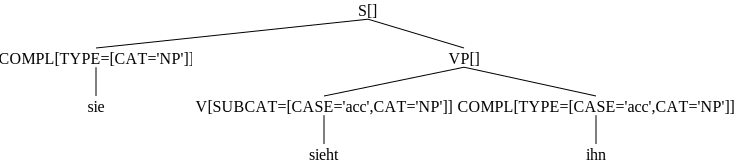

In [37]:
sent = 'sie sieht ihn'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

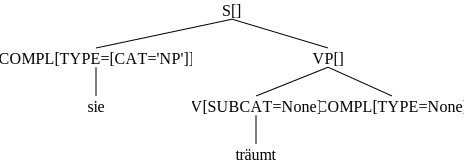

In [38]:
sent = 'sie träumt'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

In [39]:
#NEGATIVBEISPIEL:
sent = 'sie sieht'.split()
test_fcfg_grammar(gramstring, sent, draw=1)    

Keine Analyse möglich


In [40]:
#NEGATIVBEISPIEL:
sent = 'sie träumt ihn'.split()
test_fcfg_grammar(gramstring, sent, draw=1)

Keine Analyse möglich


### B) Ergänzung um Regeln für Objektkomplementsatz (`SBAR`):

In [41]:
gramstring = r"""
% start S
    
    S   -> COMPL[CAT=NP] VP
    VP  -> V[SUBCAT=?s] COMPL[TYPE=?s]

    COMPL[TYPE=[CAT=SBAR]] -> COMP S
    
   
    COMPL[TYPE=[CAT=NP]]   -> "sie"
    COMPL[TYPE=[CAT=NP, CASE=acc]]   -> "ihn"
    COMPL[TYPE=None]   ->

    V[SUBCAT=[CAT=NP,CASE=acc]]   -> "sieht"
    V[SUBCAT=None]   -> "träumt"

    V[SUBCAT=[CAT=SBAR]]   -> "glaubt"
    COMP   -> "dass"
"""

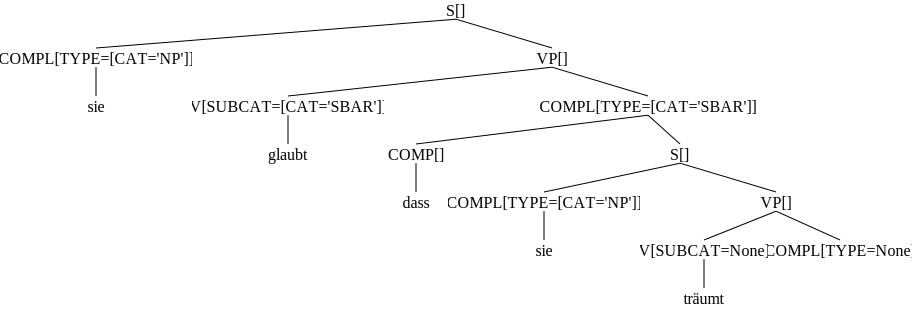

In [42]:
sent = 'sie glaubt dass sie träumt'.split()
test_fcfg_grammar(gramstring, sent, draw=1)